In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from scipy.stats import uniform, randint

# EDA

## data import

In [3]:
dirs = os.getcwd() + '/demand/'
files = os.listdir(dirs)
ac=files[42:]
ac

['서울특별시 공공자전거 이용정보(시간대별)_20.07.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_20.08.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_20.09.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_20.10.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_20.11.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_20.12.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.01.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.02.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.03.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.04.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.05.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.06.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.07.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.08.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.09.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.10.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.11.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_21.12.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_22.01.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_22.02.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_22.03.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_22.04.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_22.05.csv',
 '서울특별시 공공자전거 이용정보(시간대별)_22.06.csv']

In [4]:
column_types = {
    '대여일자': 'datetime64[ns]',
    '대여시간': 'int32',
    '대여소번호': 'category',
    '대여소': 'category',
    '대여구분코드': 'category',
    '성별': 'category',
    '연령대코드': 'category',
    '이용건수': 'float32',
    '운동량': 'float32',
    '탄소량': 'float32',
    '이동거리(M)': 'float32',
    '이동시간(분)': 'int32',
}

In [5]:
bike = pd.DataFrame()
    
total = len(ac)
for i, file in enumerate(ac, 1):
    print("%d/%d loaded..." %(i, total))

    formatter = file.split('.')[2]
    if formatter == 'xlsx':
        column_types['대여일자'] = 'datetime64[ns]'
        data = pd.read_excel(dirs + file, dtype = column_types)
    elif formatter == 'csv':
        column_types['대여일자'] = object
        data = pd.read_csv(dirs+file, dtype=column_types, parse_dates = ['대여일자'], 
                           encoding='utf-8',na_values="\\N")

        
    bike = pd.concat([bike, data])


1/24 loaded...
2/24 loaded...
3/24 loaded...
4/24 loaded...
5/24 loaded...
6/24 loaded...
7/24 loaded...
8/24 loaded...
9/24 loaded...
10/24 loaded...
11/24 loaded...
12/24 loaded...
13/24 loaded...
14/24 loaded...
15/24 loaded...
16/24 loaded...
17/24 loaded...
18/24 loaded...
19/24 loaded...
20/24 loaded...
21/24 loaded...
22/24 loaded...
23/24 loaded...
24/24 loaded...


In [6]:
#delete redundant column
bike.drop(["대여소명", '대여구분코드', '성별','연령대코드', '운동량','탄소량','이동거리','사용시간','이동거리(M)','이용시간(분)'],inplace=True, axis=1)

In [7]:
#eliminate missing value of target
print(bike.isna().sum())
bike.dropna(axis=0, inplace=True)

대여일자     0
대여시간     0
대여소번호    0
이용건수     1
dtype: int64


In [8]:
bike['대여소번호'] = bike['대여소번호'].astype(int)
bike['이용건수'] = bike['이용건수'].astype(int)

In [9]:
bike = bike.groupby(['대여일자', '대여시간','대여소번호'], as_index=False).sum()

In [10]:
bike

,대여일자,대여시간,대여소번호,이용건수
0,2020-03-01,0,102,4
1,2020-03-01,0,112,1
2,2020-03-01,0,113,3
3,2020-03-01,0,114,3
4,2020-03-01,0,115,1
...,...,...,...,...
20138069,2022-06-30,23,5305,1
20138070,2022-06-30,23,5752,1
20138071,2022-06-30,23,5853,2
20138072,2022-06-30,23,5854,1


In [11]:
#bike.to_pickle("demand/total.pkl")

## extract "서대문구" with master information

In [12]:
master = pd.read_csv("3. 공공자전거 대여소 정보(22.06월 기준).csv", encoding="utf-8")
master.head()

,대여소번호,대여소명,자치구,상세주소,위도,경도,설치시기,LCD거치대수,QR거치대수,운영방식
0,102,망원역 1번출구 앞,마포구,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2022-05-03,NaN,15.0,QR
1,103,망원역 2번출구 앞,마포구,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2022-05-03,NaN,14.0,QR
2,104,합정역 1번출구 앞,마포구,서울특별시 마포구 양화로 59,37.550629,126.914986,2022-05-12,NaN,13.0,QR
3,105,합정역 5번출구 앞,마포구,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06,NaN,5.0,QR
4,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,37.548645,126.912826,2022-05-12,NaN,12.0,QR


In [13]:
master.columns = ['대여소번호', '대여소명', '자치구', '상세주소', '위도', '경도', '설치시기', 'LCD 거치대수',
       'QR 거치대수', '운영방식']

In [14]:
#LCD 거치대수와 QR 거치대수 column의 NaN은 0을 의미함
print(master.isna().sum()!=0)
master['LCD 거치대수'].fillna(0, inplace=True)
master['QR 거치대수'].fillna(0, inplace=True)
print(master.head())

대여소번호       False
대여소명        False
자치구         False
상세주소        False
위도          False
경도          False
설치시기         True
LCD 거치대수     True
QR 거치대수      True
운영방식        False
dtype: bool
   대여소번호        대여소명  자치구               상세주소         위도          경도  \
0    102  망원역 1번출구 앞  마포구  서울특별시 마포구 월드컵로 72  37.555649  126.910629   
1    103  망원역 2번출구 앞  마포구  서울특별시 마포구 월드컵로 79  37.554951  126.910835   
2    104  합정역 1번출구 앞  마포구   서울특별시 마포구 양화로 59  37.550629  126.914986   
3    105  합정역 5번출구 앞  마포구   서울특별시 마포구 양화로 48  37.550007  126.914825   
4    106  합정역 7번출구 앞  마포구    서울특별시 마포구 독막로 4  37.548645  126.912826   

         설치시기  LCD 거치대수  QR 거치대수 운영방식  
0  2022-05-03       0.0     15.0   QR  
1  2022-05-03       0.0     14.0   QR  
2  2022-05-12       0.0     13.0   QR  
3  2015-09-06       0.0      5.0   QR  
4  2022-05-12       0.0     12.0   QR  


In [15]:
master['거치대수'] = master['LCD 거치대수']+master['QR 거치대수']

In [16]:
master_target = master.groupby("자치구")['대여소번호'].unique().loc['서대문구']
master_target

array([ 115,  116,  117,  123,  128,  131,  133,  134,  135,  137,  138,
        139,  140,  141,  159,  160,  161,  162,  163,  164,  165,  166,
        167,  169,  170,  171,  173,  175,  176,  177,  178,  179,  180,
        188,  191,  192,  194,  195,  196,  198, 3100, 3101, 3102, 3103,
       3104, 3105, 3107, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116,
       3117, 3119, 3120, 3121, 3122, 3123, 3125, 3126, 3127, 3128, 3129,
       3130, 3131, 3132, 3133, 3134, 4253, 4255, 4262, 4264, 4265, 4266,
       4267, 4269], dtype=int64)

In [17]:
bike = bike[bike['대여소번호'].isin(master_target)]
bike.shape

(589946, 4)

In [18]:
bike = bike.merge(master[['대여소명','대여소번호', '거치대수']], on="대여소번호")

## import weather data

In [19]:
dirs_w = os.getcwd() + '/weather/'
files_w = os.listdir(dirs_w)
fw = files_w[3:6]
fw

['OBS_AWS_2020.csv', 'OBS_AWS_2021.csv', 'OBS_AWS_2022.csv']

In [20]:
weather = pd.DataFrame()

total = len(fw)
for i, file_w in enumerate(fw, 1):
    print("%d/%d loaded..." %(i, total))

    data2=pd.read_csv(dirs_w+file_w, encoding='cp949')
    weather = pd.concat([weather, data2])

1/3 loaded...
2/3 loaded...
3/3 loaded...


In [21]:
weather.head()

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm)
0,412,서대문,2020-01-01 00:00,-5.8,75.6,1.0,0.0
1,412,서대문,2020-01-01 01:00,-5.5,67.7,1.3,0.0
2,412,서대문,2020-01-01 02:00,-5.4,82.3,0.7,0.0
3,412,서대문,2020-01-01 03:00,-5.4,112.5,0.7,0.0
4,412,서대문,2020-01-01 04:00,-5.4,134.7,1.1,0.0


In [22]:
weather['일시'] = weather['일시'].astype('datetime64[ns]')
weather['연'] = weather['일시'].dt.year
weather['월'] = weather['일시'].dt.month
weather['일'] = weather['일시'].dt.day
weather['대여시간'] = weather['일시'].dt.hour

In [23]:
weather.drop(weather[(weather['연'] == 2020) & (weather['월'] <=6)].index)

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),연,월,일,대여시간
4368,412,서대문,2020-07-01 00:00:00,17.3,350.8,1.0,0.0,2020,7,1,0
4369,412,서대문,2020-07-01 01:00:00,17.3,1.9,0.7,0.0,2020,7,1,1
4370,412,서대문,2020-07-01 02:00:00,17.2,5.4,0.8,0.0,2020,7,1,2
4371,412,서대문,2020-07-01 03:00:00,16.8,12.1,0.9,0.0,2020,7,1,3
4372,412,서대문,2020-07-01 04:00:00,16.4,24.6,0.5,0.0,2020,7,1,4
...,...,...,...,...,...,...,...,...,...,...,...
8755,412,서대문,2021-12-31 19:00:00,-6.4,122.2,2.3,0.0,2021,12,31,19
8756,412,서대문,2021-12-31 20:00:00,-6.7,102.1,2.1,0.0,2021,12,31,20
8757,412,서대문,2021-12-31 21:00:00,-7.4,97.9,2.7,0.0,2021,12,31,21
8758,412,서대문,2021-12-31 22:00:00,-8.0,87.2,1.6,0.0,2021,12,31,22


In [24]:
#missing value imputation
print(weather.isna().sum())

features_imputer = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '연', '월', '일', '대여시간']
imputer = KNNImputer(n_neighbors=5)
weather[features_imputer] = imputer.fit_transform(weather[features_imputer])


지점           0
지점명          0
일시           0
기온(°C)      41
풍향(deg)     20
풍속(m/s)     20
강수량(mm)    236
연            0
월            0
일            0
대여시간         0
dtype: int64


In [25]:
bike['연'] = bike['대여일자'].dt.year
bike['월'] = bike['대여일자'].dt.month
bike['일'] = bike['대여일자'].dt.day
bike['요일'] = bike['대여일자'].dt.dayofweek
bike.head()

,대여일자,대여시간,대여소번호,이용건수,대여소명,거치대수,연,월,일,요일
0,2020-03-01,0,115,1,마스타 빌딩 앞,15.0,2020,3,1,6
1,2020-03-01,1,115,2,마스타 빌딩 앞,15.0,2020,3,1,6
2,2020-03-01,2,115,1,마스타 빌딩 앞,15.0,2020,3,1,6
3,2020-03-01,3,115,1,마스타 빌딩 앞,15.0,2020,3,1,6
4,2020-03-01,5,115,1,마스타 빌딩 앞,15.0,2020,3,1,6


In [26]:
bike = bike.merge(weather, on=['연', '월', '일', '대여시간'])

In [27]:
bike.drop(["대여일자", "지점", "지점명","일시"],inplace=True, axis=1)
bike.head()

,대여시간,대여소번호,이용건수,대여소명,거치대수,연,월,일,요일,기온(°C),풍향(deg),풍속(m/s),강수량(mm)
0,0,115,1,마스타 빌딩 앞,15.0,2020,3,1,6,4.6,331.2,0.7,0.0
1,0,117,1,홍은사거리,46.0,2020,3,1,6,4.6,331.2,0.7,0.0
2,0,123,3,문화촌 공원,20.0,2020,3,1,6,4.6,331.2,0.7,0.0
3,0,128,1,신촌역(2호선) 1번출구 옆,18.0,2020,3,1,6,4.6,331.2,0.7,0.0
4,0,131,1,증산2교,20.0,2020,3,1,6,4.6,331.2,0.7,0.0


## feature engineering

In [28]:
#one hot encoding for categorical variable
bike_final = bike.join(pd.get_dummies(bike['요일'], prefix="요일"))
bike_final.drop("요일",inplace=True, axis=1)
bike_final.head()

,대여시간,대여소번호,이용건수,대여소명,거치대수,연,월,일,기온(°C),풍향(deg),풍속(m/s),강수량(mm),요일_0,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6
0,0,115,1,마스타 빌딩 앞,15.0,2020,3,1,4.6,331.2,0.7,0.0,0,0,0,0,0,0,1
1,0,117,1,홍은사거리,46.0,2020,3,1,4.6,331.2,0.7,0.0,0,0,0,0,0,0,1
2,0,123,3,문화촌 공원,20.0,2020,3,1,4.6,331.2,0.7,0.0,0,0,0,0,0,0,1
3,0,128,1,신촌역(2호선) 1번출구 옆,18.0,2020,3,1,4.6,331.2,0.7,0.0,0,0,0,0,0,0,1
4,0,131,1,증산2교,20.0,2020,3,1,4.6,331.2,0.7,0.0,0,0,0,0,0,0,1


# Model Selection with the most popular 대여소

In [29]:
print(bike_final['대여소명'].value_counts())

홍은사거리           13911
증산2교            13366
문화촌 공원          12957
증산교 앞           12534
홍연2교옆           12493
                ...  
서대문자연사박물관 입구     1157
국민연금공단충정로사옥      1047
안산초등학교 앞          509
연희IC 남측           492
독립문역 5번 출구        449
Name: 대여소명, Length: 79, dtype: int64


In [30]:
hongeun = bike_final[bike_final["대여소명"]=="홍은사거리"]
hongeun.shape

(13911, 19)

In [31]:
features=set(bike_final.columns)-set(["이용건수","대여소명","대여소번호"])
features

{'강수량(mm)',
 '거치대수',
 '기온(°C)',
 '대여시간',
 '연',
 '요일_0',
 '요일_1',
 '요일_2',
 '요일_3',
 '요일_4',
 '요일_5',
 '요일_6',
 '월',
 '일',
 '풍속(m/s)',
 '풍향(deg)'}

In [32]:
hongeun_X_train, hongeun_X_test, hongeun_Y_train, hongeun_Y_test = train_test_split(hongeun[features], hongeun['이용건수'], test_size=0.3, random_state=42)

In [33]:
print(hongeun_X_train.shape)
print(hongeun_Y_train.shape)
print(hongeun_X_test.shape)
print(hongeun_Y_test.shape)

(9737, 16)
(9737,)
(4174, 16)
(4174,)


In [34]:
models = [
    ('lr', lm.LinearRegression(n_jobs=-1)),
    ('ridge', lm.Ridge()),
    ('lasso', lm.Lasso()),
    ('elastic', lm.ElasticNet()),
    ('LassoLars', lm.LassoLars()),
    ('SGDRegressor', lm.SGDRegressor()),
    ('Perceptron', lm.Perceptron(n_jobs=-1)),
]

n = 3
params = {
    'lr' : {
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'ridge': {
        'alpha': [0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'lasso': {
        'alpha': [0.1, 1.0, 10],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    'elastic': {
        'alpha': [0.1, 1.0, 10],
        'normalize': [True, False],
        'fit_intercept': [True, False],
    },
    'LassoLars': {
        'alpha': [0.1, 1.0, 10],
        'normalize': [True, False],
        'fit_intercept': [True, False],
    },
    'SGDRegressor': {
        'penalty': ['l1', 'l2'],
        'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False],
    },
    'Perceptron' :{
        'penalty': ['None', 'l1', 'l2'],
        'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'fit_intercept': [True, False]
    },
}

In [35]:
best_model, best_mae = None, float('inf')
for model_name, model in models:
    param_grid = params[model_name]
    grid = GridSearchCV(model, cv=5, n_jobs=-1, param_grid=param_grid, verbose=2)
    grid = grid.fit(hongeun_X_train, hongeun_Y_train)

    model = grid.best_estimator_
    predictions = model.predict(hongeun_X_test)
    mae = mean_absolute_error(hongeun_Y_test, predictions)

    print(mae, model)

    if mae < best_mae:
        best_model = model
        best_mae = mae

Fitting 5 folds for each of 4 candidates, totalling 20 fits
2.7350413272640153 LinearRegression(n_jobs=-1, normalize=True)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
2.7347181970251278 Ridge(alpha=100)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
2.732256865565366 Lasso(alpha=0.1)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
2.7320660883767034 ElasticNet(alpha=0.1)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
2.7322567982429686 LassoLars(alpha=0.1, normalize=False)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


371125869555731.25 SGDRegressor(alpha=100)
Fitting 5 folds for each of 36 candidates, totalling 180 fits
4.069956875898419 Perceptron(alpha=10, n_jobs=-1, penalty='l1')


elasticNet이 MAE 2.73 정도로 제일 낮았음. 

In [36]:
best_model

ElasticNet(alpha=0.1)

# 모든 대여소에 대한 예측 모델

In [37]:
results = {}
total = bike_final['대여소명'].nunique()

for idx, (name, _df) in enumerate(bike_final.groupby('대여소명'), 1):
    print("[%d/%d] %s" %(idx, total, name), end=' ')

    try:
        X_train, X_test, y_train, y_test = train_test_split(_df[features], _df['이용건수'], test_size=0.2, random_state=42)

        param_grid = {
        'alpha': [0.1, 1.0, 10],
        'normalize': [True, False],
        'fit_intercept': [True, False],
        }

        grid = GridSearchCV(lm.ElasticNet(), cv=5, n_jobs=-1, param_grid=param_grid)
        grid = grid.fit(X_train, y_train)

        model = grid.best_estimator_
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)

        results[name] = {}
        results[name]['model'] = model
        results[name]['mae'] = mae
        results[name]['errors'] = predictions - y_test

    except:
        continue

[1/79] DMC래미안e편한세상203동옆 [2/79] DMC엘가아파트 앞 [3/79] DMC파크뷰자이1단지 110동 앞 [4/79] DMC파크뷰자이아파트 302동 앞 [5/79] SK리체블(상수도사업본부) [6/79] e편한세상 신촌4단지 앞 [7/79] 가재울 초등학교 [8/79] 가재울사거리 [9/79] 가좌삼거리 [10/79] 가좌역 4번출구 앞 [11/79] 국민연금공단충정로사옥 [12/79] 남가좌동 제2공영주차장 [13/79] 독립문역 5번 출구 [14/79] 독립문역사거리 [15/79] 동신병원 맞은편 [16/79] 래미안 루센티아 아파트 108동 앞 [17/79] 마스타 빌딩 앞 [18/79] 명물길 원형무대 앞 [19/79] 명지대학교 도서관 [20/79] 명지전문대학교 정문 앞 [21/79] 모래내고가차도 [22/79] 무악재역 4번 출구 [23/79] 무악재역1번 출구 [24/79] 문화촌 공원 [25/79] 봉원고가차도 밑 [26/79] 북가좌 삼거리 [27/79] 북가좌 초등학교 [28/79] 북가좌1동 주민센터 [29/79] 북가좌삼거리2 [30/79] 북성초교 [31/79] 북아현 치안센터 인근 [32/79] 북아현동 가구거리 [33/79] 북한산더샾 106동 앞 [34/79] 서대문구청 [35/79] 서대문역 2번 출구 [36/79] 서대문역 8번출구 앞 [37/79] 서대문자연사박물관 입구 [38/79] 서우빌딩 [39/79] 신촌기차역입구 교차로 [40/79] 신촌동 제1공영주차장 앞 [41/79] 신촌역 4번출구 [42/79] 신촌역(2호선) 1번출구 옆 [43/79] 안산초등학교 앞 [44/79] 연가교 교차로 [45/79] 연가초등학교 옆 [46/79] 연대 대운동장 옆 [47/79] 연서어린이공원 [48/79] 연세대 정문 건너편 [49/79] 연세로 명물길 [50/79] 연희 브라운스톤 아파트 앞 [51/79] 연희IC 남측 [52/79] 연희교차로 인근 [53/79] 연희삼거리 [54/79] 연희초등학교 앞 [55/

1.0786279602524527


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


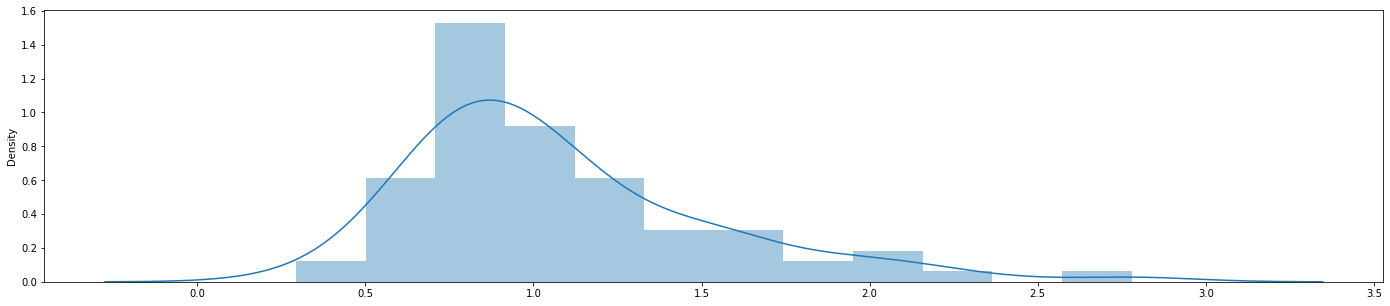

In [237]:
# 전체 평균 MAE
errors = np.array([result['mae'] for result in results.values()])
print(errors.mean()) #평균적으로 한 대 정도의 오차가 남.

# 전체 MAE 분포
plt.figure(figsize=(24, 5))
sns.distplot(errors)
plt.show()

참고문헌 : https://dailyheumsi.tistory.com/95